# Basic analysis methods within the `spatialdata` ecosystem 

In this notebook, we will explore how to use `spatialdata-plot` to generate static plots of various different technologies. When we load the `spatialdata-plot` library, this adds the `.pl` accessor to every `SpatialData` object, which gives us access to the plotting functions. Their logic is loosly inspired by the ggplot-library in R, in which one can chain multiple function calls, gradually building the final figure.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import spatialdata as sd
import spatialdata_plot
import matplotlib.pyplot as plt  # for multi-panel plots later
import scanpy as sc
import squidpy as sq

sdata_xenium = sd.read_zarr("../data/xenium_2.0.0_io_subset.zarr")

/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:21: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
# sdata_crop = sdata_xenium.query.bounding_box(
#     axes=["x", "y"],
#     min_coordinate=[25000, 5000],
#     max_coordinate=[35000, 15000],
#     target_coordinate_system="global",
# )
sdata_crop = sdata_xenium
sdata_crop

SpatialData object, with associated Zarr store: /Users/tim.treis/Documents/GitHub/spatialdata-workshops/data/xenium_2.0.0_io_subset.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 5636, 1448), (3, 2818, 724), (3, 1409, 362), (3, 704, 181), (3, 352, 90)
│     └── 'morphology_focus': DataTree[cyx] (1, 17098, 51187), (1, 8549, 25593), (1, 4274, 12796), (1, 2137, 6398), (1, 1068, 3199)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
│     └── 'nucleus_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (162254, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (162254, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (156628, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (162254, 377)
wit

In [4]:
sdata_crop.tables["table"]

AnnData object with n_obs × n_vars = 162254 × 377
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [5]:
sdata_xenium.tables["table"].uns["spatialdata_attrs"]

{'instance_key': 'cell_id', 'region': 'cell_circles', 'region_key': 'region'}

In [6]:
orig_spatialdata_attrs = sdata_crop.tables["table"].uns["spatialdata_attrs"]

In [7]:
sc.pp.filter_cells(sdata_crop.tables["table"], min_counts=10, inplace=True)
sc.pp.filter_genes(sdata_crop.tables["table"], min_cells=5, inplace=True)
sc.pp.normalize_total(sdata_crop.tables["table"], inplace=True)
sc.pp.log1p(sdata_crop.tables["table"])
sc.pp.pca(sdata_crop.tables["table"])
sc.pp.neighbors(sdata_crop.tables["table"])
sc.tl.umap(sdata_crop.tables["table"])
sc.tl.leiden(sdata_crop.tables["table"])

/var/folders/qg/qgc908995g3fc8qtss2fsbhhxyxxj4/T/ipykernel_48534/45369356.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(sdata_crop.tables["table"])


In [8]:
sdata_crop.tables["table"].uns["spatialdata_attrs"]

{'instance_key': 'cell_id', 'region': 'cell_circles', 'region_key': 'region'}

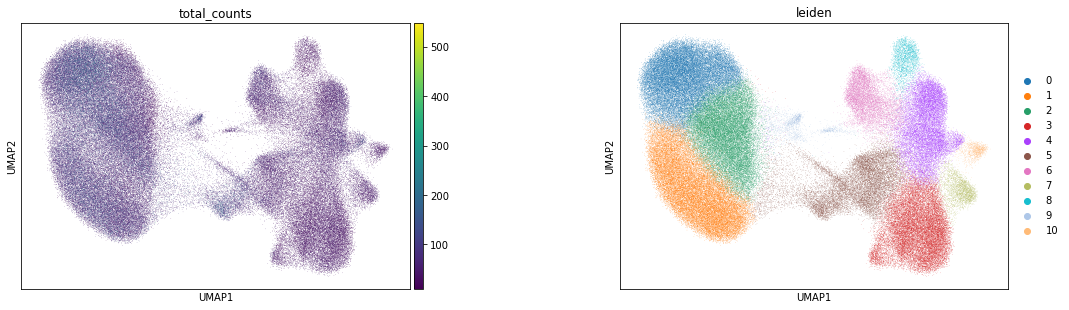

In [9]:
sc.pl.umap(
    sdata_crop.tables["table"],
    color=[
        "total_counts",
        "leiden",
    ],
    wspace=0.4,
)

In [10]:
for i in [3, 5, 6]:
    sdata_crop.tables["table"].obs["leiden"].replace(f"{i}", "0", inplace=True)

for i in range(1, 13):
    sdata_crop.tables["table"].obs["leiden"].replace(f"{i}", "1", inplace=True)

/var/folders/qg/qgc908995g3fc8qtss2fsbhhxyxxj4/T/ipykernel_48534/2869579122.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sdata_crop.tables["table"].obs["leiden"].replace(f"{i}", "0", inplace=True)
/var/folders/qg/qgc908995g3fc8qtss2fsbhhxyxxj4/T/ipykernel_48534/2869579122.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categor

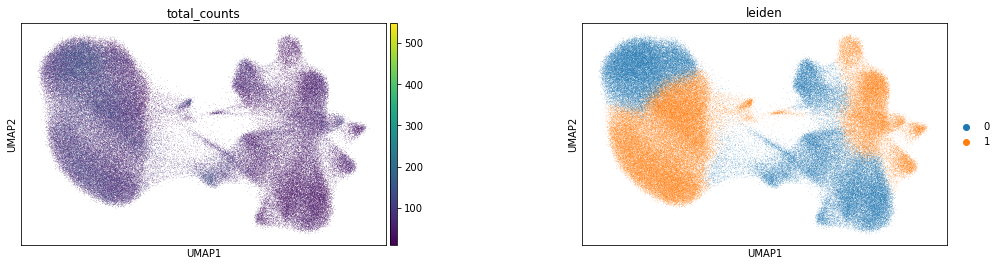

In [11]:
sc.pl.umap(
    sdata_crop.tables["table"],
    color=[
        "total_counts",
        "leiden",
    ],
    wspace=0.4,
)

In [12]:
sdata_crop.tables["table"].obs["leiden"].value_counts().sum()

154472

In [13]:
sdata_crop.tables["table"]

AnnData object with n_obs × n_vars = 154472 × 377
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatialdata_attrs', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

KeyError: 'leiden_colors'

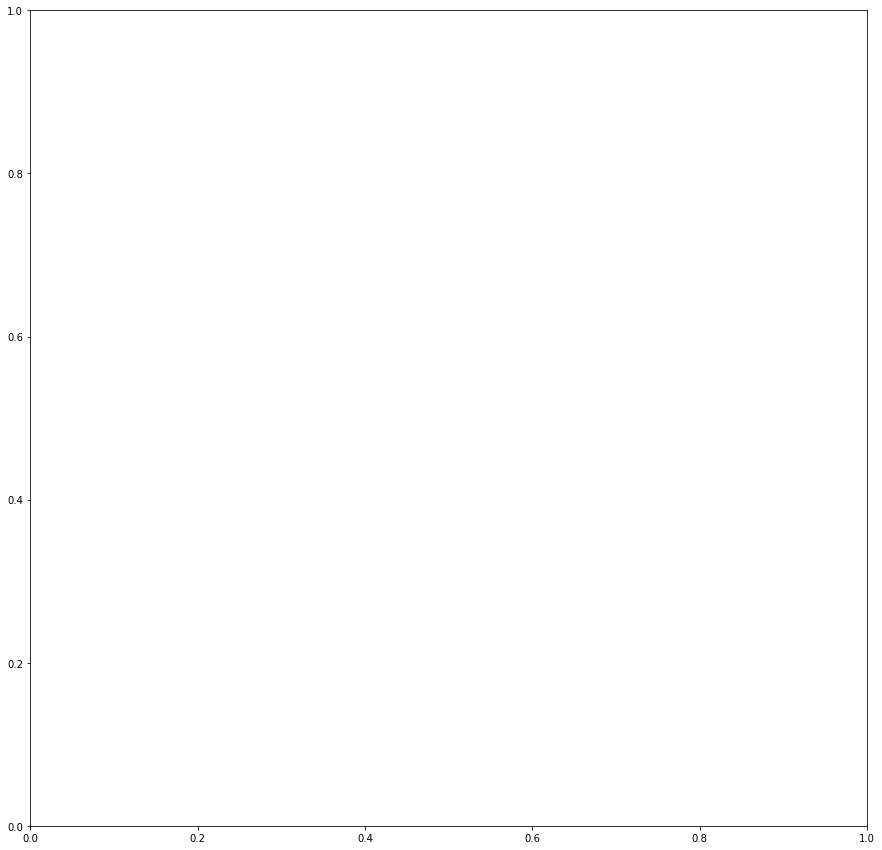

In [14]:
sdata_cropfig, ax = plt.subplots(1, 1, figsize=(15, 15))

sdata_crop.pl.render_shapes("cell_circles", color="leiden", ).pl.show(
    ax=ax
)

In particular, the library exposes the following funcitons:
- [`Spatialdata.pl.render_images()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_images)
- [`Spatialdata.pl.render_labels()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_labels)
- [`Spatialdata.pl.render_points()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_points)
- [`Spatialdata.pl.render_shapes()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_shapes)
- [`Spatialdata.pl.show()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.show)

We can chain the 4 `render_xxx` functions to gradually build up a figure, with a final call to `show` to then actually render out the function. In the following sections we will explore these functions further.


## Overview
- [Simple function calls](#simple-viz)
- [Stacking function calls](#stacked-viz)
- [Transformations](#transformations)
- [Best practises](#best-practises)

## Simple function calls <a id="simple-viz"></a>
Let's first focus on the [MERFISH](https://vizgen.com/technology/) data from the previous notebook. As we can see below, it contains slots for `Images`, `Points`, `Shapes`, and `Tables`.

In [ ]:
sdata_xenium

SpatialData object, with associated Zarr store: /Users/tim.treis/Documents/GitHub/spatialdata-workshops/data/xenium_2.0.0_io_subset.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 5636, 1448), (3, 2818, 724), (3, 1409, 362), (3, 704, 181), (3, 352, 90)
│     └── 'morphology_focus': DataTree[cyx] (1, 17098, 51187), (1, 8549, 25593), (1, 4274, 12796), (1, 2137, 6398), (1, 1068, 3199)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
│     └── 'nucleus_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (162254, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (162254, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (156628, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (162254, 377)
wit

INFO     Rasterizing image for faster rendering.                                                                   


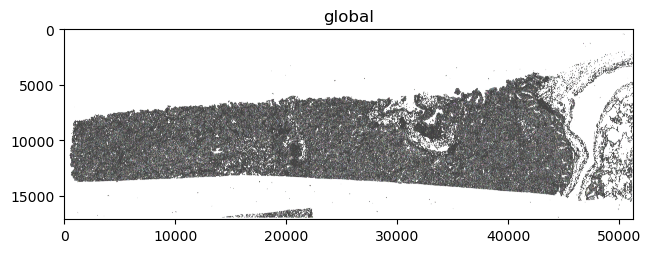

In [ ]:
sdata_xenium.pl.render_labels("cell_labels").pl.show()

In [ ]:
sc.pp.filter_cells(sdata_xenium.tables["table"], min_counts=10)
sc.pp.filter_genes(sdata_xenium.tables["table"], min_cells=5)

/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/qg/qgc908995g3fc8qtss2fsbhhxyxxj4/T/ipykernel_91588/2474886349.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(sdata_xenium.tables["table"])


In [ ]:
sdata_xenium.tables["table"].obs

cell_id  transcript_counts  control_probe_counts  \
1       aaaaficg-1                 19                     0   
2       aaabbaka-1                 53                     0   
3       aaabbjoo-1                 29                     0   
4       aaablchg-1                 42                     0   
5       aaacaicl-1                135                     0   
...            ...                ...                   ...   
162244  oipogjpd-1                 12                     0   
162245  oipoiane-1                 11                     0   
162246  oipolbma-1                 10                     0   
162247  oippajff-1                 13                     0   
162248  ojaacmoj-1                 11                     0   

        control_codeword_counts  unassigned_codeword_counts  \
1                             0                           0   
2                             0                           0   
3                             0                           0   
4                             0                           1   
5                             0                           0   
...                         ...                         ...   
162244                        0                           0   
162245                        0                           0   
162246                        0                           0   
162247                        0                           0   
162248                        0                           0   

        deprecated_codeword_counts  total_counts   cell_area  nucleus_area  \
1                                0            19   49.130002     21.268595   
2                                0            53  119.618911     74.778753   
3                                0            29   94.241097     59.109533   
4                                0            43  120.341411     52.426408   
5                                0           135  197.965007     56.084065   
...                            ...           ...         ...           ...   
162244                           0            12    6.818594      6.818594   
162245                           0            11   13.140469     13.140469   
162246                           0            10   34.634845      8.940938   
162247                           0            13   33.731720      5.644531   
162248                           0            11   14.540313     14.540313   

              region  z_level  nucleus_count  cell_labels  n_counts leiden  
1       cell_circles      0.0            1.0            2      19.0      3  
2       cell_circles      0.0            1.0            3      53.0      2  
3       cell_circles      0.0            1.0            4      29.0      0  
4       cell_circles      0.0            1.0            5      42.0      2  
5       cell_circles      0.0            2.0            6     135.0      2  
...              ...      ...            ...          ...       ...    ...  
162244  cell_circles      7.0            1.0       162245      12.0     10  
162245  cell_circles      6.0            1.0       162246      11.0      3  
162246  cell_circles      5.0            1.0       162247      10.0      5  
162247  cell_circles      7.0            1.0       162248      13.0      3  
162248  cell_circles      5.0            1.0       162249      11.0      6  

[154472 rows x 15 columns]

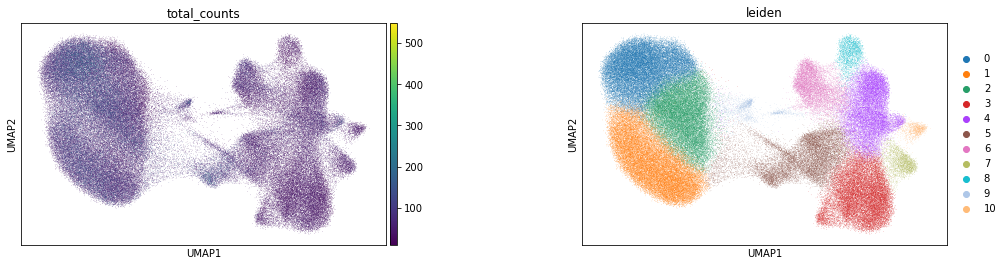

In [ ]:
sc.pl.umap(
    sdata_xenium.tables["table"],
    color=[
        "total_counts",
        "leiden",
    ],
    wspace=0.4,
)

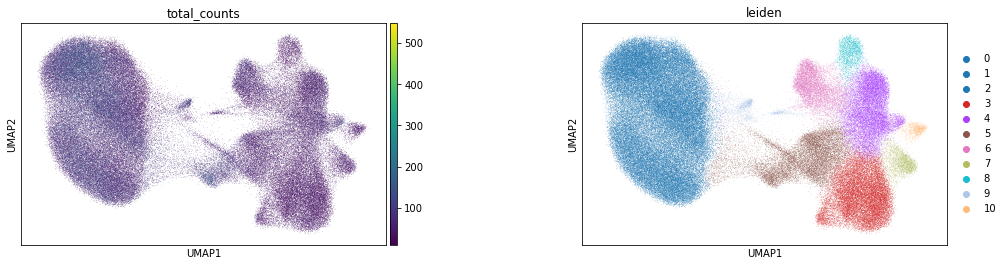

In [ ]:
sc.pl.umap(
    sdata_xenium.tables["table"],
    color=[
        "total_counts",
        "leiden",
    ],
    wspace=0.4,
)

In [ ]:
sdata_xenium.tables["table"].uns["leiden_colors"] = [
    "#1f77b4",
    "#1f77b4",
    "#1f77b4",
    "#d62728",
    "#aa40fc",
    "#8c564b",
    "#e377c2",
    "#b5bd61",
    "#17becf",
    "#aec7e8",
    "#ffbb78",
]

INFO     Rasterizing image for faster rendering.                                                                   


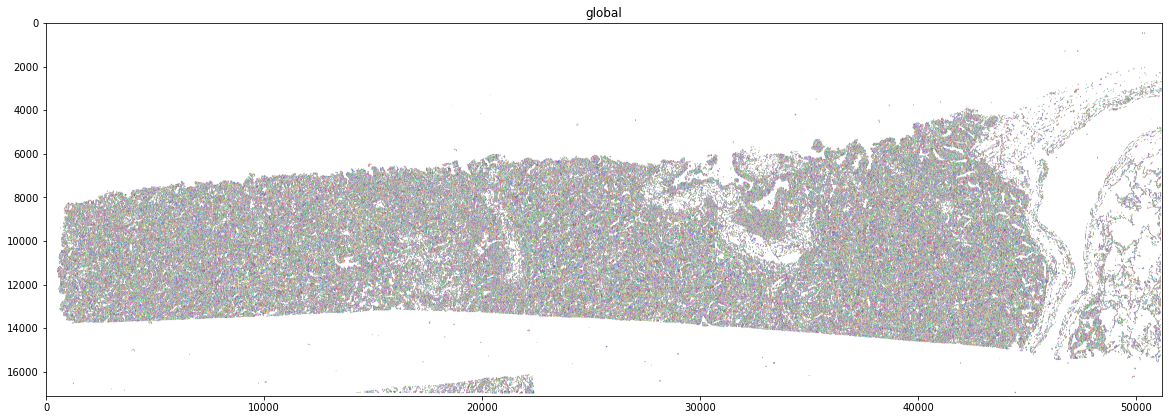

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20, 10))

sdata_xenium.pl.render_labels("cell_labels", color="leiden", outline_alpha=0).pl.show(ax=ax)

In [ ]:
sdata_crop = sdata_xenium.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[25000, 5000],
    max_coordinate=[35000, 15000],
    target_coordinate_system="global",
)

In [ ]:
sdata_xenium.tables["table"].obs["leiden"].replace("1", "0", inplace=True)
sdata_xenium.tables["table"].obs["leiden"].replace("2", "0", inplace=True)

/var/folders/qg/qgc908995g3fc8qtss2fsbhhxyxxj4/T/ipykernel_91588/881690359.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  sdata_xenium.tables["table"].obs["leiden"].replace("1", "0", inplace=True)
/var/folders/qg/qgc908995g3fc8qtss2fsbhhxyxxj4/T/ipykernel_91588/881690359.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  sdata_xenium.tables["table"].obs["leiden"].replace("2", "0", inplace=True)


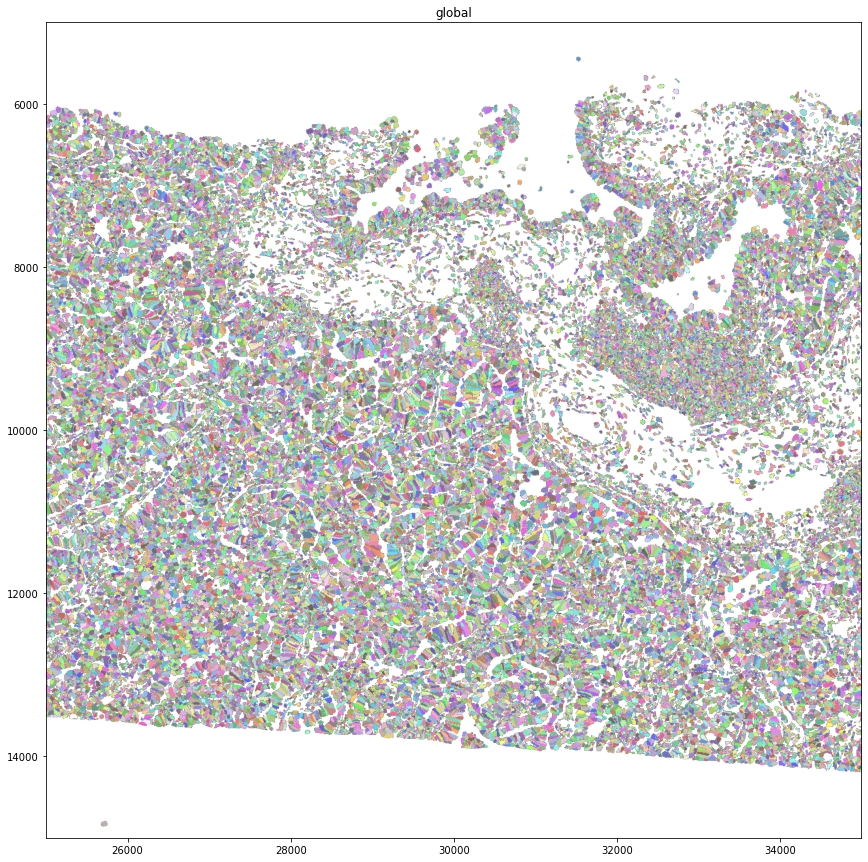

In [ ]:
sdata_cropfig, ax = plt.subplots(1,1,figsize=(15, 15))

sdata_crop.pl.render_labels("cell_labels", color="leiden", outline_alpha=0).pl.show(ax=ax)

In [ ]:
sdata_crop.tables["table"].obs["leiden"].value_counts()

leiden
0     14785
3      6537
5      3951
4      3126
6      1690
9      1094
7       764
8       443
10      281
Name: count, dtype: int64

Let's first visualise the individual contained modalities separately. 

## Transformations <a id="transformations"></a>
While this particular dataset is already (mostly) aligned correctly, we will use it to demonstrate the transformation logic of the `spatialdata` ecosystem. For the sake of this exercise, we will assume that the `Shapes` layer containing the anatomical regions needs to be adjusted to better match the "VISp_II/III" point annotation. We will use the `spatialdata` transformation logic to do so.

Using the [`spatialdata.transformations.get_transformations()`](https://spatialdata.scverse.org/en/latest/generated/spatialdata.transformations.get_transformation.html) function, we can extract the original transformation to the coordinate system it maps to:

In [ ]:
sq.gr.spatial_neighbors(
    sdata_merfish,
    elements_to_coordinate_systems={"cells": "global"},
    table_key="table"
)
sdata_merfish.tables["table"]

AnnData object with n_obs × n_vars = 2389 × 268
    obs: 'cell_id', 'region'
    uns: 'spatialdata_attrs', 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [ ]:
sq.gr.nhood_enrichment(sdata_merfish, cluster_key="region")

ValueError: Expected at least `2` clusters, found `1`.